In [1]:
import sys
import os
sys.path.insert(0, '../')

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from typing import Tuple
from pickle import load

from src.vg2signal import read_raw_vg_as_df, make_smoother, make_shoulder_getter, make_detilter
from src.load_dataset import load_dataset
from src.utils import tsen_pca_viz, verify_batch_label_dist, calculate_r2_score, calculate_per_diff, per_error, find_adj_score, perform_combat_normalization

from src.generate_dataset import v2signal_extra_features

In [2]:
def load_dataset_raw(dataset_path=None, split=False) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    if dataset_path==None: dataset_path = DATASET_PATH

    if ('ML1_ML2'in os.path.basename(dataset_path)) or ('test' in os.path.basename(dataset_path)):
        datasets = sorted([f"{i}/raw_data.pickle" for i in glob(f'{dataset_path}/*')])
        
        df = []
        for dataset in datasets:

            with open(dataset, 'rb') as f:
                data = load(f)
                df.append(data) 
        df = pd.concat(df)

    else:
        dataset_path = f"{dataset_path}/raw_data.pickle"
        with open(dataset_path, 'rb') as f:
            df = load(f)

    X = [x.iloc[0] for (_,x) in df[['VI']].iterrows()] 
    X = np.array(X)
    y = df['labels'].apply(lambda x: float(x))
    
    if split:
        # Split the total dataset into training (60%) and testing (40%) dataset
        X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=20, stratify=y)

        return (X_train, X_test, y_train, y_test), (None, None)
    else:
        return [None]*4, (X, y)


In [3]:
def find_outliers_name():
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), (ML1_X, ML1_y)  = load_dataset_raw('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1')
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), (ML2_X, ML2_y)  = load_dataset_raw('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2')
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), (ML4_X, ML4_y)  = load_dataset_raw('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4')

    
    return ML1_X, ML1_y

In [4]:
ML1_X, ML1_y = find_outliers_name()

In [114]:
ML1_y

0     8.0
0     8.0
0    16.0
0    16.0
0    16.0
     ... 
0     0.0
0    16.0
0    16.0
0     8.0
0     8.0
Name: labels, Length: 131, dtype: float64

In [7]:
# Load dataset
normalization    = False
standardize_type = 'mean_std' if normalization else 'none'
split            = False
combat_norm      = False
showFileName     = True

if split:
    (ML1_X_train, ML1_X_test, ML1_y_train, ML1_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML2_X_train, ML2_X_test, ML2_y_train, ML2_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    (ML4_X_train, ML4_X_test, ML4_y_train, ML4_y_test), _  = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

else:
    ML1_X, ML1_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_19_ML1', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML2_X, ML2_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML1_ML2/2024_02_22_ML2', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)
    ML4_X, ML4_y = load_dataset('/Users/sangam/Desktop/Epilepsey/Code/vgramreg/dataset/ML4', normalization=normalization, standardize_type=standardize_type, split=split, showFileName=showFileName)

In [8]:
ML1_X['y']        = ML1_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML1_X['filename'] = ML1_y

ML2_X['y']        = ML2_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML2_X['filename'] = ML2_y

ML4_X['y']        = ML4_y.apply(lambda x: int(x.split('_')[-2].replace('cbz','')))
ML4_X['filename'] = ML4_y

In [9]:
ML1_X['vcenter'][(ML1_X['filename'].apply(lambda x: True if ('2024_02_19_cbz08_37.txt' in x) else False))]

86    1.0
Name: vcenter, dtype: float64

Dataset Name:  ML1
lower boundary 0.9592500000000002 upper boundary 1.1200500000000002
Above_upper_bound: []  |  Lower_bound ['2024_02_19_cbz00_16.txt' '2024_02_19_cbz00_30.txt'
 '2024_02_19_cbz00_18.txt' '2024_02_19_cbz00_33.txt'
 '2024_02_19_cbz08_37.txt']


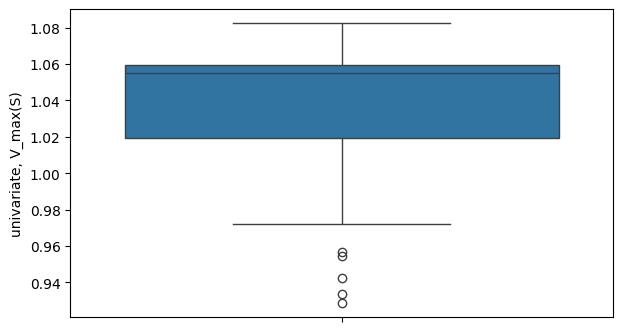


Dataset Name:  ML2
lower boundary 0.9745250000000003 upper boundary 1.1059249999999996
Above_upper_bound: []  |  Lower_bound ['2024_02_22_cbz00_17.txt' '2024_02_22_cbz00_01.txt'
 '2024_02_22_cbz08_01.txt' '2024_02_22_cbz00_40.txt'
 '2024_02_22_cbz00_23.txt' '2024_02_22_cbz00_30.txt'
 '2024_02_22_cbz00_32.txt']


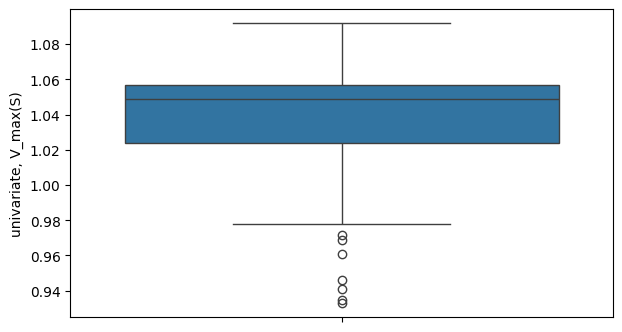


Dataset Name:  ML4
lower boundary 0.9854499999999995 upper boundary 1.0910500000000003
Above_upper_bound: ['2024_03_08_cbz00_31.txt' '2024_03_08_cbz00_32.txt'
 '2024_03_08_cbz00_38.txt' '2024_03_08_cbz00_07.txt']  |  Lower_bound ['2024_03_08_cbz00_35.txt' '2024_03_08_cbz00_24.txt'
 '2024_03_08_cbz00_19.txt' '2024_03_08_cbz00_27.txt'
 '2024_03_08_cbz00_33.txt' '2024_03_08_cbz00_42.txt'
 '2024_03_08_cbz00_01.txt' '2024_03_08_cbz00_11.txt'
 '2024_03_08_cbz00_04.txt' '2024_03_08_cbz00_10.txt'
 '2024_03_08_cbz00_06.txt' '2024_03_08_cbz00_13.txt']


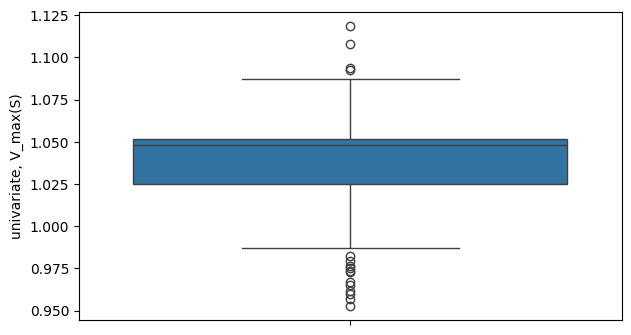

In [72]:
# data    = ML1_X.copy()
feature = 'univariate, V_max(S)'
# sns.boxplot(data, x='y', y=feature)

# Find outliers 
for data, name in zip([ML1_X.copy(), ML2_X.copy(), ML4_X.copy()], ['ML1', 'ML2', 'ML4']):
    print("Dataset Name: ",name)
    
    Q1  = np.percentile(data[feature], q=25)
    Q3  = np.percentile(data[feature], q=75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    above_upper_bound = data[[feature, 'filename']][(data[feature]>upper_bound)]
    above_lower_bound = data[[feature, 'filename']][(data[feature]<lower_bound)]

    print("lower boundary", lower_bound, "upper boundary", upper_bound)
    print("Above_upper_bound:", above_upper_bound['filename'].values, " | ","Lower_bound",  above_lower_bound['filename'].values)
    
    plt.figure(figsize=(7,4))
    sns.boxplot(data, y=feature)
    plt.show()
    print()

In [10]:
ML1_X

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)",y,filename
0,3.9270,74.8319,1.0592,1.060,0.057938,0.0056,0.0143,1.2795,-1.4044,2.6839,1.028,1.084,0.1159,8,2024_02_19_cbz08_16.txt
1,3.1525,71.2312,1.0596,1.060,0.048110,0.0045,0.0117,1.0918,-1.2233,2.3151,1.032,1.088,0.0962,8,2024_02_19_cbz08_02.txt
2,8.3259,169.0758,1.0579,1.060,0.126038,0.0119,0.0307,2.6995,-3.0750,5.7746,1.032,1.084,0.2521,16,2024_02_19_cbz16_16.txt
3,5.1395,117.3360,1.0714,1.076,0.081811,0.0073,0.0196,1.8314,-2.1638,3.9952,1.040,1.096,0.1636,16,2024_02_19_cbz16_02.txt
4,7.1913,170.9573,1.0578,1.060,0.109513,0.0103,0.0264,2.4115,-2.5560,4.9674,1.028,1.084,0.2190,16,2024_02_19_cbz16_03.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1.2807,83.9311,1.0003,1.000,0.015235,0.0018,0.0040,0.4498,-0.5339,0.9837,0.960,1.064,0.0305,0,2024_02_19_cbz00_43.txt
126,5.1873,117.3580,1.0561,1.056,0.076948,0.0074,0.0189,1.7284,-1.8158,3.5442,1.028,1.084,0.1539,16,2024_02_19_cbz16_27.txt
127,5.8157,126.6233,1.0605,1.060,0.084659,0.0083,0.0210,1.8284,-2.0389,3.8673,1.024,1.092,0.1693,16,2024_02_19_cbz16_33.txt
128,3.4449,79.6460,1.0552,1.056,0.050678,0.0049,0.0124,1.0982,-1.0913,2.1895,1.032,1.084,0.1014,8,2024_02_19_cbz08_27.txt


In [15]:
ML1_X

,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)",y,filename
0,3.9270,74.8319,1.0592,1.060,0.057938,0.0056,0.0143,1.2795,-1.4044,2.6839,1.028,1.084,0.1159,8,2024_02_19_cbz08_16.txt
1,3.1525,71.2312,1.0596,1.060,0.048110,0.0045,0.0117,1.0918,-1.2233,2.3151,1.032,1.088,0.0962,8,2024_02_19_cbz08_02.txt
2,8.3259,169.0758,1.0579,1.060,0.126038,0.0119,0.0307,2.6995,-3.0750,5.7746,1.032,1.084,0.2521,16,2024_02_19_cbz16_16.txt
3,5.1395,117.3360,1.0714,1.076,0.081811,0.0073,0.0196,1.8314,-2.1638,3.9952,1.040,1.096,0.1636,16,2024_02_19_cbz16_02.txt
4,7.1913,170.9573,1.0578,1.060,0.109513,0.0103,0.0264,2.4115,-2.5560,4.9674,1.028,1.084,0.2190,16,2024_02_19_cbz16_03.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,1.2807,83.9311,1.0003,1.000,0.015235,0.0018,0.0040,0.4498,-0.5339,0.9837,0.960,1.064,0.0305,0,2024_02_19_cbz00_43.txt
126,5.1873,117.3580,1.0561,1.056,0.076948,0.0074,0.0189,1.7284,-1.8158,3.5442,1.028,1.084,0.1539,16,2024_02_19_cbz16_27.txt
127,5.8157,126.6233,1.0605,1.060,0.084659,0.0083,0.0210,1.8284,-2.0389,3.8673,1.024,1.092,0.1693,16,2024_02_19_cbz16_33.txt
128,3.4449,79.6460,1.0552,1.056,0.050678,0.0049,0.0124,1.0982,-1.0913,2.1895,1.032,1.084,0.1014,8,2024_02_19_cbz08_27.txt


It seems hard to detect outlier with only use Inter-quartile range

In [11]:
from pyod.models.knn import KNN

In [85]:
all_combined = pd.concat([ML1_X, ML2_X, ML4_X], axis=0).reset_index(drop=True)

In [111]:
label = 16.
data  = all_combined[all_combined['y']==label].copy()
tx    = data.drop(columns=['filename','y'])
knn   = KNN(contamination=0.03,method='mean',n_neighbors=5) 

knn.fit(tx)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [112]:
knn_scores    = knn.decision_scores_
knn_scores_df = pd.DataFrame(knn_scores,index=tx.index,
                                           columns=['score'])

In [113]:
knn.threshold_

13.978663065404888

In [114]:
outlier_indx = knn_scores_df[knn_scores_df['score'] >= knn.threshold_].sort_values('score', ascending=False).index.to_list()
outlier_indx

[20, 290, 259, 11]

In [115]:
data.loc[outlier_indx]['filename']

20     2024_02_19_cbz16_38.txt
290    2024_03_08_cbz16_27.txt
259    2024_03_08_cbz16_40.txt
11     2024_02_19_cbz16_01.txt
Name: filename, dtype: object

In [116]:
(np.array(range(len(data)))==data.index.values).all()

False

In [117]:
from pyod.models.lof import LOF

In [118]:
lof = LOF(contamination=0.03, n_neighbors=5) 
lof.fit(tx)

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)

In [119]:
predicted = pd.Series(lof.predict(tx),index=tx.index) 
print('Number of outliers = ', predicted.sum())
outliers = data[predicted == 1] 
outliers = data.loc[outliers.index] 
outliers

Number of outliers =  2


,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)",y,filename
11,4.4046,62.0707,1.0727,1.068,0.062544,0.0063,0.0158,1.2983,-1.4957,2.7940,1.044,1.104,0.1251,16,2024_02_19_cbz16_01.txt
20,3.6751,33.7654,1.0555,1.044,0.050849,0.0053,0.0131,1.0274,-1.2818,2.3092,1.020,1.096,0.1017,16,2024_02_19_cbz16_38.txt


In [120]:
from pyod.models.iforest import IForest

In [121]:
iforest = IForest(contamination=0.03,n_estimators=100,
                                             random_state=0) 
iforest.fit(tx)
predicted = pd.Series(iforest.predict(tx),index=tx.index)
print('Number of outliers = ', predicted.sum())

outliers = predicted[predicted > 0.8] 
outliers = data.loc[outliers.index] 
outliers['filename'].map(lambda x: x.replace('.txt', ''))


Number of outliers =  4


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


11     2024_02_19_cbz16_01
20     2024_02_19_cbz16_38
339    2024_03_08_cbz16_15
340    2024_03_08_cbz16_01
Name: filename, dtype: object

In [97]:
from pyod.models.ocsvm import OCSVM
ocsvm = OCSVM(contamination=0.03, kernel='rbf') 
ocsvm.fit(tx)
predicted = pd.Series(ocsvm.predict(tx),index=tx.index)
print('Number of outliers = ', predicted.sum())

outliers = predicted[predicted == 1] 
outliers = data.loc[outliers.index] 
outliers 

Number of outliers =  4


/Users/sangam/miniconda3/envs/vgramreg/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


,"univariate, area(S)",peak curvature,"univariate, V_max(S)",vcenter,"univariate, max(S)","univariate, mean(S)","univariate, std(S)","univariate, max(dS/dV)","univariate, min(dS/dV)","univariate, max(dS/dV) - min(dS/dV)","univariate, V_max(dS/dV)","univariate, V_min(dS/dV)","univariate, area(dS/dV)",y,filename
79,0.4331,1.2222,1.0105,1.008,0.006714,0.0006,0.0015,0.1792,-0.2493,0.4286,1.000,1.060,0.0134,0,2024_02_19_cbz00_09.txt
137,-0.6261,114.2405,0.9690,1.000,0.000000,-0.0009,0.0019,0.2755,-0.4292,0.7046,1.024,0.940,0.0000,0,2024_02_22_cbz00_01.txt
263,0.5532,68.7926,0.9729,1.000,0.008164,0.0008,0.0019,0.4330,-0.3632,0.7962,0.960,1.040,0.0163,0,2024_03_08_cbz00_19.txt
347,1.0049,86.9807,1.0088,1.008,0.013185,0.0014,0.0035,0.4888,-0.5200,1.0088,0.980,1.068,0.0264,0,2024_03_08_cbz00_02.txt
